In [1]:
import numpy as np 
import os
from astropy.io import fits
import healpy as hp
from scipy.interpolate import RegularGridInterpolator, griddata
from healpy.projector import GnomonicProj
import datetime
from zoneinfo import ZoneInfo
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
import matplotlib.image as mpig
from astropy.wcs import WCS
from gwcs.wcstools import wcs_from_points
from astropy.modeling.projections import Sky2Pix_TAN, Sky2Pix_STG, Sky2Pix_ARC, Sky2Pix_ZEA, Sky2Pix_SIN
#from astropy.modeling import projections
import asdf 
import matplotlib.pyplot as plt
import cv2
import rawpy
from scipy.spatial.transform import Rotation as R

In [ ]:
class all_sky_rotate():
    def __init__(self, filepath, sex_ext, rdata, ogwcs_radec, otab, rdeg):
        self.filepath = filepath
        self.sex = sex_ext
        self.rawdata = rdata
        self.cutdata = None
        self.new_gwcs = 0
        self.cen_rd = None
        self.gwcs_radec = ogwcs_radec
        self.fproj = Sky2Pix_ARC()
        self.ctab = None
        self.otab = otab      
        self.cen = [0, 0, 0]
        self.rdeg = rdeg # the radius of center region in degree

    def _set_center(self):
        width, height = self.rawdata.shape
        self.cen = [round(height/2.), round(width/2.), round(width/10.)]
        dpix = 50.0
        ra0, dec0 = self.gwcs_radec(self.cen[0],self.cen[1])
        ra1, dec1 = self.gwcs_radec(self.cen[0],self.cen[1]+dpix)
        angle = hp.rotator.angdist([ra0, dec0], [ra1, dec1],lonlat=True)
        self.cen[2] = round(np.deg2rad(self.rdeg)/angle[0] *dpix)
        print('[x, y, r]: ',self.cen)
        return

    def _set_cutdata(self):
        col1 = self.cen[0]-self.cen[2]
        col2 = self.cen[0]+self.cen[2]
        row1 = self.cen[1]-self.cen[2]
        row2 = self.cen[1]+self.cen[2]
        self.cutdata = self.rawdata[row1:row2,col1:col2]  

    def get_proj(self):
        proj_name = self.gwcs_radec.forward_transform[3].__class__.__name__
        proj_name = proj_name.split('_')[-1]
        proj_abb = ''.join(filter(str.isupper, proj_name))
        str_proj = ['TAN', 'STG', 'ARC', 'ZEA', 'SIN']
        f_proj = [Sky2Pix_TAN(), Sky2Pix_STG(), Sky2Pix_ARC(), Sky2Pix_ZEA(), Sky2Pix_SIN()]
        self.fproj = f_proj[str_proj.index(proj_abb)]

    def get_center_tab(self):  
        sel_fit = fits.PrimaryHDU(np.array(self.cutdata))
        sel_fit.writeto(self.filepath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+self.filepath+'sel_fit.fits -O --use-source-extractor'\
                  +' --source-extractor-path '+self.sex \
                    +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                        +' --cpulimit 30 >> ' +self.filepath+'sel_fit.txt')
        if os.path.exists(self.filepath+'sel_fit.corr'):
            self.ctab = fits.open(self.filepath+'sel_fit.corr')[1].data
            os.remove(self.filepath+'sel_fit.corr') 
            w = WCS(fits.open(self.filepath+'sel_fit.wcs')[0].header)
            cen_rd = w.wcs_pix2world([[self.cen[2], self.cen[2]]], 1)[0]
            self.cen_rd = SkyCoord(cen_rd[0], cen_rd[1], unit=(u.deg, u.deg))
            os.remove(self.filepath+'sel_fit.wcs') 
        else:
            print("The zenith region can not be solved.") 
    
    def rot_tab(self):
        ira, idec = self.gwcs_radec(self.ctab['field_x'],self.ctab['field_y'])
        in_points = hp.ang2vec(np.deg2rad(90. -idec),np.deg2rad(ira))
        out_points = hp.ang2vec(np.deg2rad(90. -self.ctab['index_dec']),np.deg2rad(self.ctab['index_ra']))
        in_c = np.mean(in_points, axis=0)
        out_c = np.mean(out_points, axis=0)
        in_points = in_points - in_c
        out_points = out_points - out_c

        rotation, cost = R.align_vectors(out_points, in_points)
        euler_angles = rotation.as_euler('zyx')
        euler_angles[0] = -euler_angles[0]
        rotation = R.from_euler('zyx', euler_angles)
        r_matrix = rotation.as_matrix()
        #r_matrix[0,1] = -r_matrix[0,1]
        #r_matrix[1,0] = -r_matrix[1,0]
        in_ps = hp.ang2vec(np.deg2rad(90. -self.otab['index_dec']),np.deg2rad(self.otab['index_ra']))
        out_ps = out_c + np.dot(in_ps -in_c, r_matrix)
        new_dec, new_ra = hp.vec2ang(out_ps)
        new_dec = 90. -np.rad2deg(new_dec)
        new_ra = np.rad2deg(new_ra)

        tab_radec = SkyCoord(new_ra, new_dec, unit=(u.deg, u.deg),frame='icrs')
        xy = ((self.otab['field_x'],self.otab['field_y']))
        self.new_gwcs = wcs_from_points(xy, tab_radec, proj_point=self.cen_rd,\
                             projection=self.fproj,poly_degree=6, polynomial_type='polynomial')
 
    def get_gwcs(self):
        self._set_center()   
        self._set_cutdata() 
        self.get_proj()
        self.get_center_tab()    
        self.ctab['field_x'] = np.round(self.ctab['field_x']-self.cen[2] + self.cen[0])
        self.ctab['field_y'] = np.round(self.ctab['field_y']-self.cen[2] + self.cen[1])
        print('The center area is solved.')
        self.rot_tab()   
        print('The new_gwcs is obtained.') 

In [ ]:
sex_ext = '/usr/local/bin/sex ' # source extractor
ipath = 'your image path'

# Obtain the results of coordinate transformation
ofile = ipath+'result_gwcs_radec.asdf'
asdf_file = asdf.open(ofile)
ogwcs_radec = asdf_file.tree['wcs']
otab = Table.read(ipath + 'img_stars_coords.csv')

ifile = ipath+'result_gwcs_radec_n.asdf'
asdf_file = asdf.open(ifile)
igwcs_radec = asdf_file.tree['wcs']
itab = Table.read(ipath + 'img_stars_coords_n.csv')

fname = 't2020-10-19_06-14-38.jpg'
img = mpig.imread(ipath+fname)
rr = img[:,:,0]
gg = img[:,:,1]
bb = img[:,:,2]
gimg = (0.299*rr + 0.587*gg + 0.114*bb)

In [7]:
res = all_sky_rotate(ipath, sex_ext, gimg, ogwcs_radec, otab, 15.0)
res.get_gwcs()

[x, y, r]:  [2592, 1728, 270]


The center area is solved.
The new_gwcs is obtained.


/tmp/ipykernel_99405/4099442238.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(gimg))


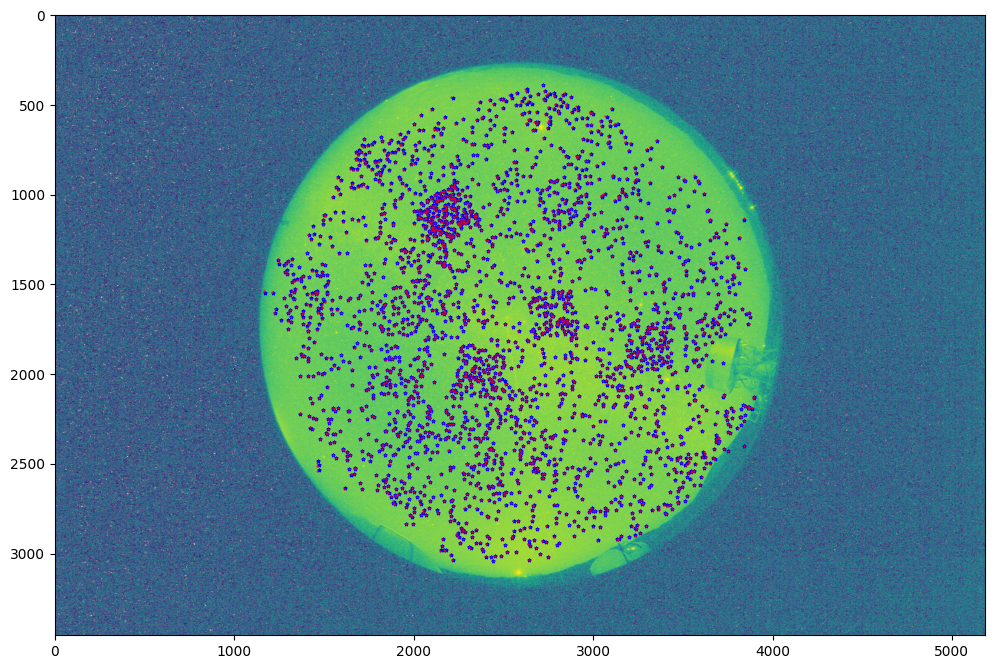

In [8]:
gx, gy = res.new_gwcs.backward_transform(itab['index_ra'], itab['index_dec'])

fig,ax = plt.subplots(figsize=(12,12),dpi=100)
ax.imshow(np.log10(gimg))
plt.scatter(gx,gy, c='blue',s=5,marker='*')
plt.scatter(itab['field_x'],itab['field_y'],s=1,marker='.',c='red')#,edgecolors='red', linewidths=0.5)
plt.show()

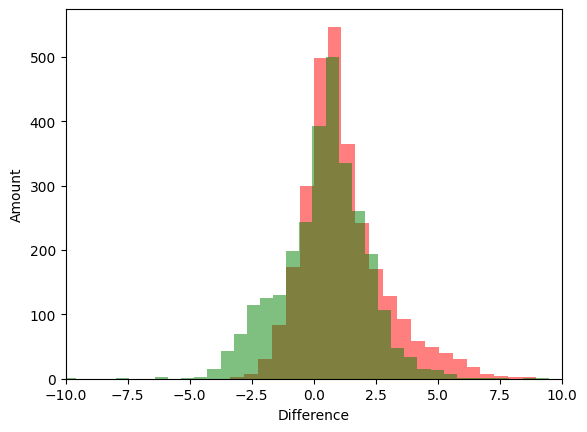

In [13]:
plt.hist(gx-itab['field_x'], bins=50, color='red', alpha=0.5)
plt.hist(gy-itab['field_y'], bins=50, color='green', alpha=0.5)
plt.xlim(-10,10)
plt.xlabel('Difference')
plt.ylabel('Amount')
plt.show()

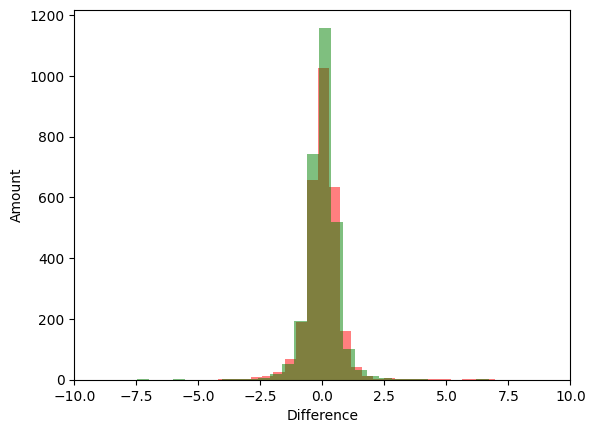

In [14]:
igx, igy = igwcs_radec.backward_transform(itab['index_ra'], itab['index_dec'])
plt.hist(igx-itab['field_x'], bins=50, color='red', alpha=0.5)
plt.hist(igy-itab['field_y'], bins=50, color='green', alpha=0.5)
plt.xlim(-10,10)
plt.xlabel('Difference')
plt.ylabel('Amount')
plt.show()